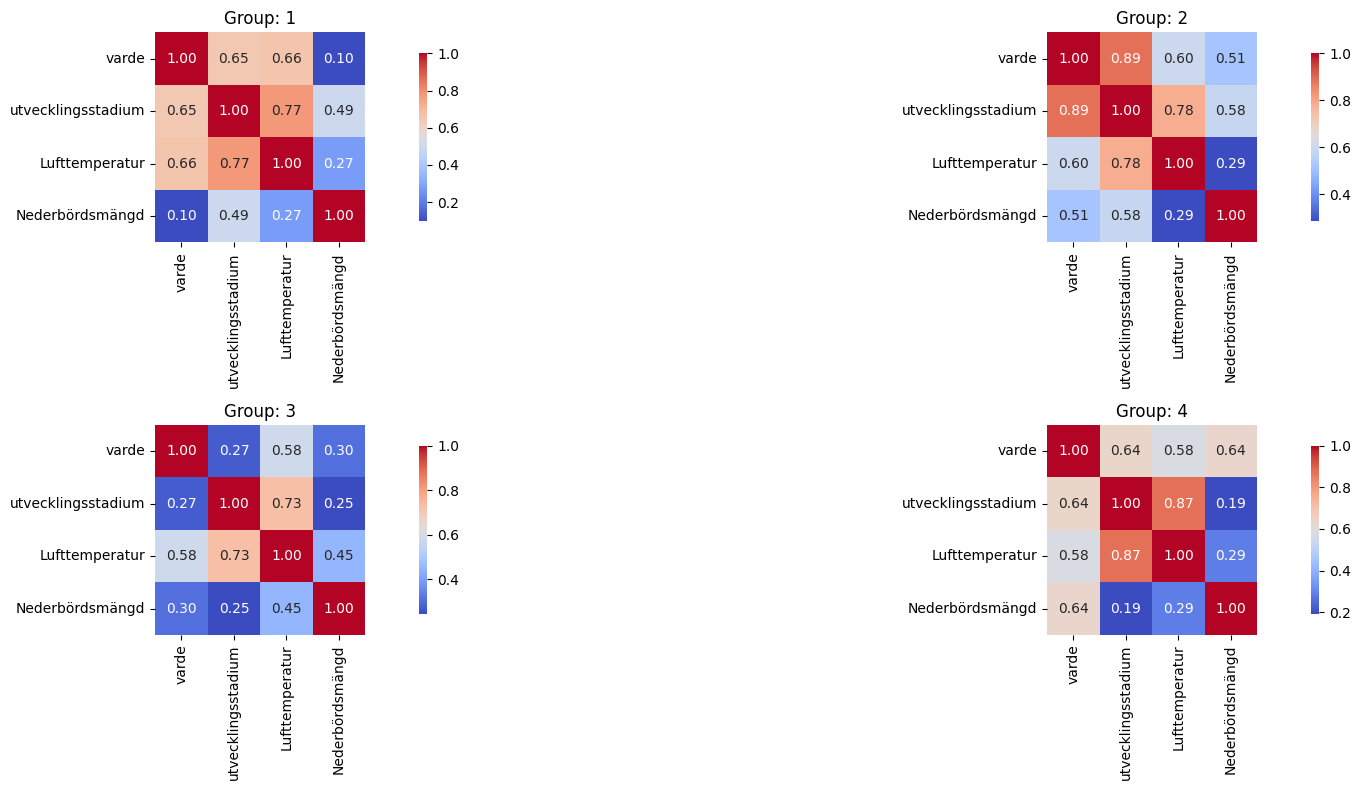

In [2]:
import pandas as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('data.csv')
crop = df['groda'][0]
pest = df['skadegorare'][0]
df = df.drop(['groda', 'skadegorare'], axis=1)

def assign_growth_zone(geometry_str):
    coords = geometry_str.replace('POINT (', '').replace(')', '').split()
    latitude = float(coords[1]) 
    if latitude < 60.0:
        return 0 #'Southern Sweden'
    elif 60.0 <= latitude <= 64.0:
        return 1 #'Central Sweden'
    else:
        return 2 #'Northern Sweden'
    
df['GrowthZone'] = df['geometry'].apply(assign_growth_zone)

def replace_nan_with_avg(df, column):
    for i in range(len(df)):
        if pd.isna(df.loc[i, column]): 
            if i == 0: 
                df.loc[i, column] = df.loc[i + 1, column]
            elif i == len(df) - 1: 
                df.loc[i, column] = df.loc[i - 1, column]
            else: 
                prev_val = df.loc[i - 1, column]
                next_val = df.loc[i + 1, column]
                df.loc[i, column] = (prev_val + next_val) / 2

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    if df[col].isna().any(): 
        replace_nan_with_avg(df, col)

df['graderingsdatum'] = pd.to_datetime(df['graderingsdatum'], errors='coerce')
df['Year'] = df['graderingsdatum'].dt.year
years_to_keep = [2019]
df = df[df['Year'].isin(years_to_keep)]

df.loc[:, 'GrowthZone'] = pd.to_numeric(df['GrowthZone'], errors='coerce')
df.loc[:, 'Year'] = pd.to_numeric(df['Year'], errors='coerce')

x_c = 2
y_c = 2
n = x_c * y_c

groups = df.groupby('geometry')
group_sizes = groups.size()
top_groups = group_sizes.nlargest(n).index  

fig, axes = plt.subplots(x_c, y_c, figsize=(20, 8))
axes = axes.flatten() 

for i, name in enumerate(top_groups):
    group_df = df[df['geometry'] == name]
    group_df = group_df.sort_values(by='graderingsdatum')
    group_df = group_df.drop(columns=['geometry', 'graderingsdatum', 'Year', 'GrowthZone'], errors='ignore')

    corr = group_df.corr()
    
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True, ax=axes[i], cbar_kws={"shrink": .8})
    axes[i].set_title(f'Group: {i+1}')

plt.tight_layout()
plt.show()


In [3]:
group_df = df[df['geometry'] == top_groups[0]].drop(columns=['geometry', 'Year', 'GrowthZone'], errors='ignore')
group_df

,varde,utvecklingsstadium,graderingsdatum,Lufttemperatur,Nederbördsmängd
5511,30.0,30.0,2019-04-08,3.628571,0.0
5541,20.0,30.0,2019-04-15,5.600000,0.0
5563,20.0,31.0,2019-04-22,14.200000,13.3
5717,10.0,32.0,2019-04-29,8.071429,11.4
5893,10.0,37.0,2019-05-06,9.128571,6.1
6084,30.0,39.0,2019-05-13,13.071429,9.1
6270,32.0,41.0,2019-05-20,13.657143,7.4
6470,46.0,47.0,2019-05-27,13.500000,13.8
6668,42.0,57.0,2019-06-03,16.857143,11.3
6865,40.0,65.0,2019-06-10,18.100000,22.1


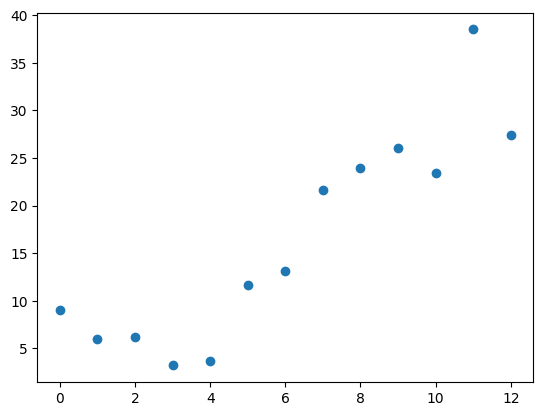

In [4]:
scale_factor = group_df['utvecklingsstadium'] / 100
scale_varde = scale_factor * group_df['varde']
plt.scatter(range(len(scale_factor)), scale_varde)

In [5]:
from xrf import XRandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

group_df_resampled = group_df.set_index('graderingsdatum').resample('D').interpolate()

X = np.array(group_df_resampled.drop(['varde'], axis=1))
y = np.array(group_df_resampled['varde'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rfx = XRandomForestRegressor(n_jobs=-1)
rfx.fit(X_train, y_train)
preds = rfx.predict(X_test)


# Evaluate predictions
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error (MAE): 1.0666
Mean Squared Error (MSE): 1.5288
R² Score: 0.9919


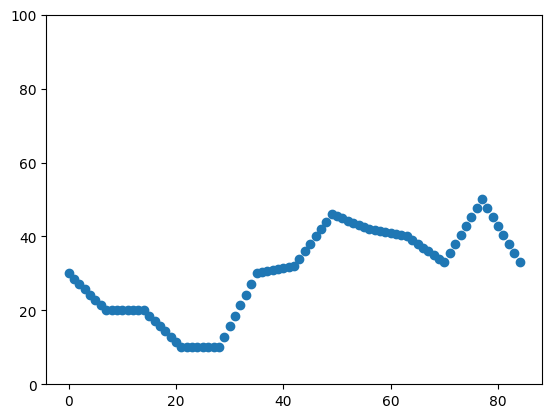

In [6]:
plt.scatter(range(len(group_df_resampled['varde'])), group_df_resampled['varde'])
plt.ylim(0, 100)
plt.show()

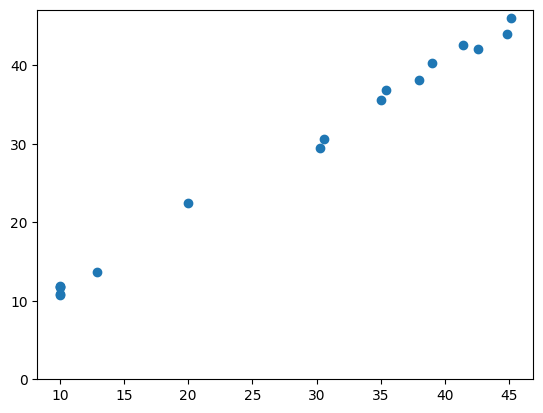

In [8]:
plt.scatter(y_test, preds)
plt.ylim(0, max(preds)+1)
plt.show()

In [44]:
knime_df = pd.read_csv('test_jbv.csv', encoding='ISO-8859-1')
knime_df = knime_df.drop(['graderingsdatums', 'graderingsdatums(shifted)'], axis=1)
print(knime_df.shape)
knime_df.head()

(20744, 7)


,RegionID,Mean(vardes),Mean(utvecklingsstadiums),First*(ekologisk),First(delomrades),week,target
0,Row0_1,33.0,24.0,0,Blekinge,16,6.0
1,Row0_1,6.0,30.0,0,Blekinge,17,4.0
2,Row0_1,4.0,30.0,0,Blekinge,18,3.0
3,Row0_1,3.0,31.0,0,Blekinge,19,3.0
4,Row0_1,3.0,32.0,0,Blekinge,20,1.0


In [31]:
print(len(np.unique(knime_df['First*(ekologisk)'])))
print(len(np.unique(knime_df['First(delomrades)'])))
print(len(np.unique(knime_df['week'])))
print(len(np.unique(knime_df['Mean(vardes)'])))
print(len(np.unique(knime_df['target'])))
print(len(np.unique(knime_df['RegionID'])))

2
33
17
290
253
1955


In [33]:
vals = np.unique(knime_df['RegionID'])
print(vals)

['Row0_1' 'Row0_10' 'Row0_100' ... 'Row0_997' 'Row0_998' 'Row0_999']


In [34]:
knime_df.rename(columns={'RegionID': 'FieldID'}, inplace=True)
knime_df.head()

,FieldID,Mean(vardes),Mean(utvecklingsstadiums),First*(ekologisk),First(delomrades),week,target
0,Row0_1,33.0,24.0,0,Blekinge,16,6.0
1,Row0_1,6.0,30.0,0,Blekinge,17,4.0
2,Row0_1,4.0,30.0,0,Blekinge,18,3.0
3,Row0_1,3.0,31.0,0,Blekinge,19,3.0
4,Row0_1,3.0,32.0,0,Blekinge,20,1.0


In [39]:
df_encoded = pd.get_dummies(knime_df, columns=['FieldID', 'First(delomrades)', 'First*(ekologisk)'], dtype=int)

In [40]:
print(df_encoded.shape)
df_encoded.head()

(20744, 1994)


,Mean(vardes),Mean(utvecklingsstadiums),week,target,FieldID_Row0_1,FieldID_Row0_10,FieldID_Row0_100,FieldID_Row0_1000,FieldID_Row0_1001,FieldID_Row0_1002,...,First(delomrades)_Västra skaraborg,First(delomrades)_Västra Östergötland,First(delomrades)_Älvsborg,First(delomrades)_Öland,First(delomrades)_Örebro län,First(delomrades)_Östra Södermanland,First(delomrades)_Östra skaraborg,First(delomrades)_Östra Östergötland,First*(ekologisk)_0,First*(ekologisk)_1
0,33.0,24.0,16,6.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,6.0,30.0,17,4.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,4.0,30.0,18,3.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3.0,31.0,19,3.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,3.0,32.0,20,1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [46]:
df_cleaned = df_encoded.dropna()
print(df_cleaned.shape)

(14988, 1994)


In [ ]:
X = np.array(df_cleaned.drop(['target'], axis=1))
y = np.array(df_cleaned['target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rfx = XRandomForestRegressor(n_jobs=-1)
rfx.fit(X_train, y_train)
preds = rfx.predict(X_test)


# Evaluate predictions
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

ValueError: Input y contains NaN.